In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import glob
import os
import seaborn as sns
import optuna

In [5]:
def PCA_analysis(directory, scaler, n_components):
    
    full_paths = glob.glob(os.path.join(directory, 'spins_iter-*.csv'))

    flist = []
    for filename in full_paths:
        df = pd.read_csv(filename, header=None) 
        flist.append(df)

    arraylist = []
    for file in flist:
        array = file.to_numpy()
        flattened_array = array.flatten()
        arraylist.append(flattened_array)
        
    df = pd.DataFrame(arraylist)
    
    print(df)

    scaled = scaler.fit_transform(df)

    pca = sklearn.decomposition.PCA(n_components)
    pca.fit(scaled)

    principal_components = pca.transform(scaled)
    return principal_components

def cluster_and_plot(pca, fig_name, model=sklearn.cluster.KMeans(n_clusters=2, random_state=42)):
    cluster_labels = model.fit_predict(principal_components)

    pdf = pd.DataFrame(data=principal_components)
    pdf['cluster'] = cluster_labels

    sns.pairplot(pdf, hue='cluster', diag_kind='kde')
    my_suptitle = plt.suptitle('Pairplot of Principal Components by Cluster', y=1.05)
    plt.savefig(f'{fig_name}', bbox_inches='tight',bbox_extra_artists=[my_suptitle])
    plt.show()
    
def clusters(pca, model=sklearn.cluster.KMeans(n_clusters=2, random_state=42)):
    cluster_labels = model.fit_predict(pca)

    return cluster_labels

In [50]:
def PCA_analysis_all_data(directories, data_set_label, scaler, n_components):
    
    df_list = []

    all_labels = [] 
    for i, directory in enumerate(directories):

        label = data_set_label[i]
            
        full_paths = glob.glob(os.path.join(directory, 'spins_iter-*.csv'))

        flist = []
        for filename in full_paths:
            df = pd.read_csv(filename, header=None) 
            flist.append(df)
            all_labels.append(label)

        arraylist = []
        for file in flist:
            array = file.to_numpy()
            flattened_array = array.flatten()
            arraylist.append(flattened_array)
        
        df = pd.DataFrame(arraylist)
        df_list.append(df)


    merged_df = pd.concat(df_list, ignore_index=True) 
    labels = pd.Series(all_labels, name='dataset')
 
    scaled = scaler.fit_transform(merged_df)

    pca = sklearn.decomposition.PCA(n_components)
    pca.fit(scaled)

    principal_components = pca.transform(scaled)

    pc_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])
    pc_df['dataset'] = labels
    sns.pairplot(pc_df, hue='dataset')
    plt.show()
    return principal_components

def cluster_and_plot(pca, fig_name, model=sklearn.cluster.KMeans(n_clusters=2, random_state=42)):
    cluster_labels = model.fit_predict(principal_components)

    pdf = pd.DataFrame(data=principal_components)
    pdf['cluster'] = cluster_labels

    sns.pairplot(pdf, hue='cluster', diag_kind='kde')
    my_suptitle = plt.suptitle('Pairplot of Principal Components by Cluster', y=1.05)
    plt.savefig(f'{fig_name}', bbox_inches='tight',bbox_extra_artists=[my_suptitle])
    plt.show()
    
def clusters(pca, model=sklearn.cluster.KMeans(n_clusters=2, random_state=42)):
    cluster_labels = model.fit_predict(pca)

    return cluster_labels

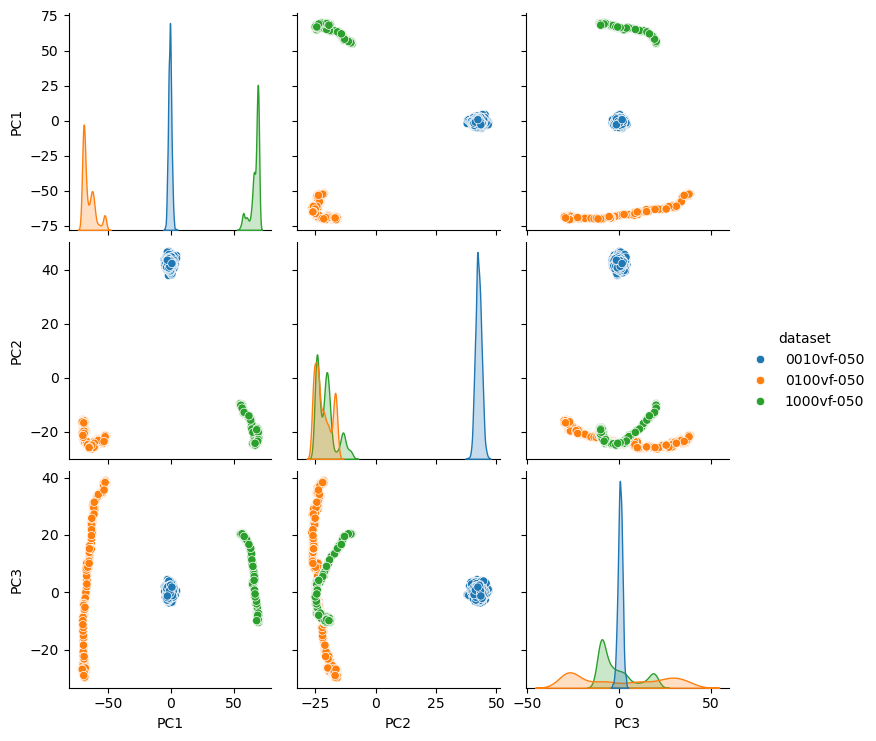

In [51]:
directory_list = ['/home/user/IsingData/Data/betaJ-0010_vf-050_nrows-100_ncols-100', '/home/user/IsingData/Data/betaJ-0100_vf-050_nrows-100_ncols-100', '/home/user/IsingData/Data/betaJ-1000_vf-050_nrows-100_ncols-100']

dataset_label = ['0010vf-050', '0100vf-050', '1000vf-050']

principal_components = PCA_analysis_all_data(directories=directory_list, data_set_label=dataset_label, n_components=3, scaler=sklearn.preprocessing.MaxAbsScaler())


In [8]:
directory_path = '/home/user/IsingData/Data/betaJ-0010_vf-050_nrows-100_ncols-100'

PCA_analysis(directory=directory_path, n_components=2, scaler=sklearn.preprocessing.StandardScaler())

      0     1     2     3     4     5     6     7     8     9     ...  9990  \
0        1     1     1    -1     1    -1     1    -1    -1     1  ...     1   
1       -1     1    -1    -1     1     1    -1     1    -1    -1  ...    -1   
2       -1     1     1    -1    -1    -1     1     1    -1    -1  ...    -1   
3       -1     1    -1    -1     1     1    -1     1     1     1  ...    -1   
4        1     1     1    -1    -1    -1     1     1     1    -1  ...    -1   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1995     1    -1    -1     1     1     1    -1    -1     1    -1  ...    -1   
1996    -1    -1     1    -1     1     1    -1    -1    -1     1  ...     1   
1997     1    -1     1     1     1    -1     1    -1    -1     1  ...    -1   
1998     1    -1    -1    -1    -1    -1    -1     1     1     1  ...    -1   
1999    -1    -1    -1    -1     1    -1     1    -1    -1     1  ...    -1   

      9991  9992  9993  9994  9995  9996  9997  999

array([[ 0.20228132, -3.30135605],
       [-0.90353472, -3.95002055],
       [-1.61382025, -7.84222662],
       ...,
       [-8.53904754,  7.0324496 ],
       [14.63330812,  0.04206605],
       [ 4.07126884, -5.56194957]], shape=(2000, 2))

## betaJ 0010

In [6]:
def objective(trial):
    
    directory_path = '/home/user/IsingData/Data/betaJ-0010_vf-050_nrows-100_ncols-100'

    n_components = trial.suggest_int("n_components", 2, 6)
    scaler_type = trial.suggest_categorical('scaler_type', ['StandardScaler', 'MinMaxScaler', 'RobustScaler', 'MaxAbsScaler', 'PowerTransformer'])

    if scaler_type ==  'StandardScaler':
        scaler_type = sklearn.preprocessing.StandardScaler()
    elif scaler_type == 'MinMaxScaler':
        scaler_type = sklearn.preprocessing.MinMaxScaler()
    elif scaler_type == 'RobustScaler':
        scaler_type = sklearn.preprocessing.RobustScaler()
    elif scaler_type == 'MaxAbsScaler':
        scaler_type = sklearn.preprocessing.MaxAbsScaler()
    elif scaler_type == 'PowerTransformer':
        scaler_type = sklearn.preprocessing.PowerTransformer()

    pca = PCA_analysis(directory=directory_path, n_components=n_components, scaler=scaler_type)
    cluster_labels = clusters(pca=pca)

    score = sklearn.metrics.silhouette_score(pca, cluster_labels)

    return score

study = optuna.create_study(direction='maximize', study_name='pca_kmeans_optimization')
    
with open('betaJ-0010_vf-050.out', 'w') as f:
    print("Starting PCA and KMeans hyperparameter optimization")
    study.optimize(objective, n_trials=3)
    print("Optimization finished.")
    print("\nPCA and KMeans Optimization Results:", file=f)
    print(f"Number of finished trials: {len(study.trials)}", file=f)
    print(f"Best trial:", file=f)
    print(f"  Value (Silhouette Score): {study.best_value:.4f}", file=f)
    print(f"  Params: {study.best_params}", file=f)

best_n_components = study.best_params['n_components']
scaler_type = study.best_params['scaler_type']

if scaler_type ==  'StandardScaler':
    scaler_type = sklearn.preprocessing.StandardScaler()
elif scaler_type == 'MinMaxScaler':
    scaler_type = sklearn.preprocessing.MinMaxScaler()
elif scaler_type == 'RobustScaler':
    scaler_type = sklearn.preprocessing.RobustScaler()
elif scaler_type == 'MaxAbsScaler':
    scaler_type = sklearn.preprocessing.MaxAbsScaler()
elif scaler_type == 'PowerTransformer':
    scaler_type = sklearn.preprocessing.PowerTransformer()

directory_path = '/home/user/IsingData/Data/betaJ-0010_vf-050_nrows-100_ncols-100'

principal_components = PCA_analysis(directory=directory_path, n_components=best_n_components, scaler=scaler_type)
cluster_and_plot(pca=principal_components, fig_name='betaJ-0010_vf-050.png')

[I 2025-07-11 20:10:18,542] A new study created in memory with name: pca_kmeans_optimization


Starting PCA and KMeans hyperparameter optimization


[W 2025-07-11 20:10:31,605] Trial 0 failed with parameters: {'n_components': 6, 'scaler_type': 'PowerTransformer'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/user/miniconda3/envs/Ising/lib/python3.13/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_2001/4122713212.py", line 19, in objective
    pca = PCA_analysis(directory=directory_path, n_components=n_components, scaler=scaler_type)
  File "/tmp/ipykernel_2001/1520158001.py", line 16, in PCA_analysis
    df = pd.DataFrame(arraylist)
  File "/home/user/miniconda3/envs/Ising/lib/python3.13/site-packages/pandas/core/frame.py", line 851, in __init__
    arrays, columns, index = nested_data_to_arrays(
                             ~~~~~~~~~~~~~~~~~~~~~^
        # error: Argument 3 to "nested_data_to_arrays" has incompatible
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<4 line

KeyboardInterrupt: 

## betaJ 0100

[I 2025-07-09 14:41:26,517] A new study created in memory with name: pca_kmeans_optimization


Starting PCA and KMeans hyperparameter optimization


/home/user/miniconda3/envs/Ising/lib/python3.13/site-packages/numpy/_core/_methods.py:193: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/user/miniconda3/envs/Ising/lib/python3.13/site-packages/numpy/_core/_methods.py:204: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
[I 2025-07-09 14:42:01,026] Trial 0 finished with value: 0.48681458527007904 and parameters: {'n_components': 4, 'scaler_type': 'PowerTransformer'}. Best is trial 0 with value: 0.48681458527007904.
[I 2025-07-09 14:42:14,654] Trial 1 finished with value: 0.4492930088975834 and parameters: {'n_components': 5, 'scaler_type': 'RobustScaler'}. Best is trial 0 with value: 0.48681458527007904.
[I 2025-07-09 14:42:27,229] Trial 2 finished with value: 0.4346167616816404 and parameters: {'n_components': 6, 'scaler_type': 'StandardScaler'}. Best is trial 0 with value: 0.48681458527007904.


Optimization finished.


/home/user/miniconda3/envs/Ising/lib/python3.13/site-packages/numpy/_core/_methods.py:193: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/user/miniconda3/envs/Ising/lib/python3.13/site-packages/numpy/_core/_methods.py:204: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


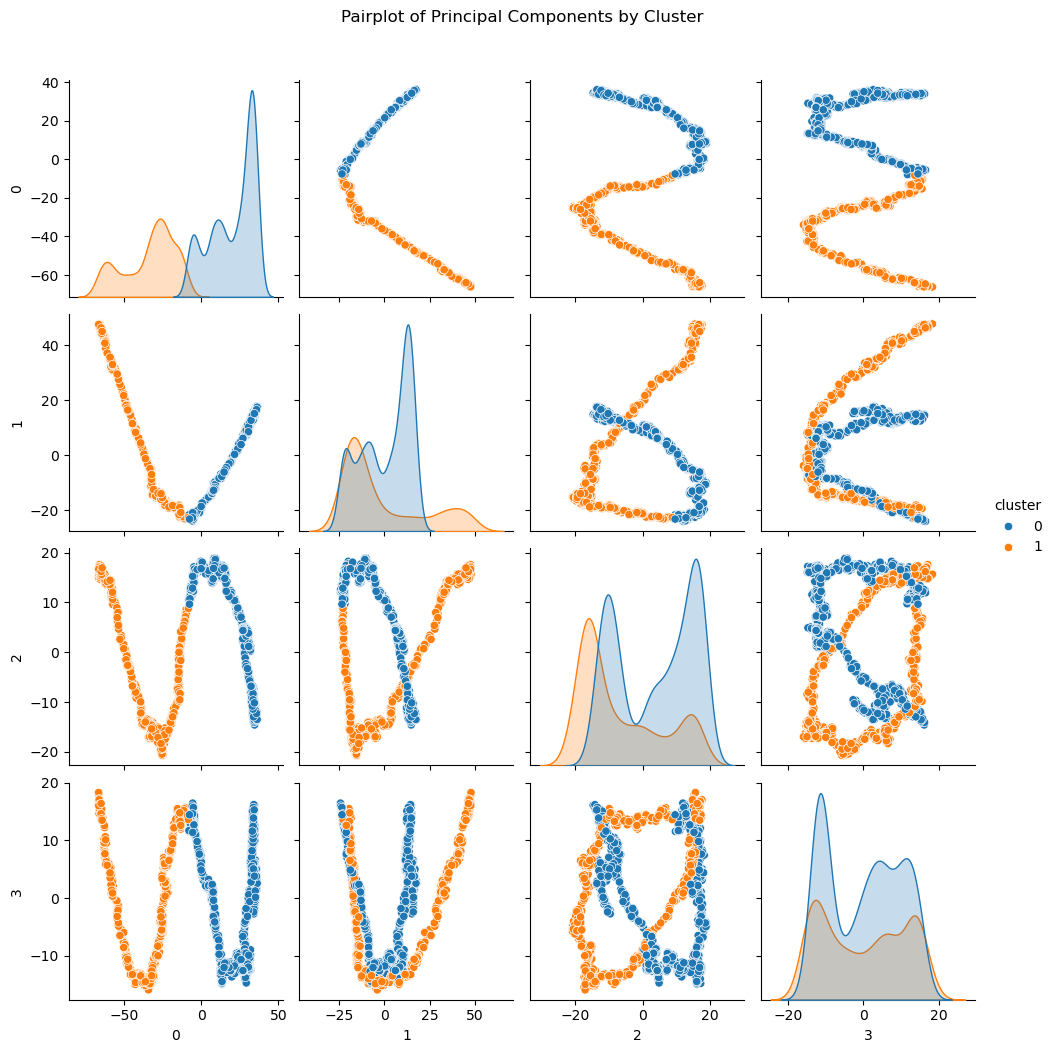

In [4]:
def objective(trial):
    
    directory_path = '/home/user/IsingData/Data/betaJ-0100_vf-050_nrows-100_ncols-100'

    n_components = trial.suggest_int("n_components", 2, 6)
    scaler_type = trial.suggest_categorical('scaler_type', ['StandardScaler', 'MinMaxScaler', 'RobustScaler', 'MaxAbsScaler', 'PowerTransformer'])

    if scaler_type ==  'StandardScaler':
        scaler_type = sklearn.preprocessing.StandardScaler()
    elif scaler_type == 'MinMaxScaler':
        scaler_type = sklearn.preprocessing.MinMaxScaler()
    elif scaler_type == 'RobustScaler':
        scaler_type = sklearn.preprocessing.RobustScaler()
    elif scaler_type == 'MaxAbsScaler':
        scaler_type = sklearn.preprocessing.MaxAbsScaler()
    elif scaler_type == 'PowerTransformer':
        scaler_type = sklearn.preprocessing.PowerTransformer()

    pca = PCA_analysis(directory=directory_path, n_components=n_components, scaler=scaler_type)
    cluster_labels = clusters(pca=pca)

    score = sklearn.metrics.silhouette_score(pca, cluster_labels)

    return score

study = optuna.create_study(direction='maximize', study_name='pca_kmeans_optimization')
    
with open('betaJ-0010_vf-050.out', 'w') as f:
    print("Starting PCA and KMeans hyperparameter optimization")
    study.optimize(objective, n_trials=3)
    print("Optimization finished.")
    print("\nPCA and KMeans Optimization Results:", file=f)
    print(f"Number of finished trials: {len(study.trials)}", file=f)
    print(f"Best trial:", file=f)
    print(f"  Value (Silhouette Score): {study.best_value:.4f}", file=f)
    print(f"  Params: {study.best_params}", file=f)

best_n_components = study.best_params['n_components']
scaler_type = study.best_params['scaler_type']

if scaler_type ==  'StandardScaler':
    scaler_type = sklearn.preprocessing.StandardScaler()
elif scaler_type == 'MinMaxScaler':
    scaler_type = sklearn.preprocessing.MinMaxScaler()
elif scaler_type == 'RobustScaler':
    scaler_type = sklearn.preprocessing.RobustScaler()
elif scaler_type == 'MaxAbsScaler':
    scaler_type = sklearn.preprocessing.MaxAbsScaler()
elif scaler_type == 'PowerTransformer':
    scaler_type = sklearn.preprocessing.PowerTransformer()

directory_path = '/home/user/IsingData/Data/betaJ-0100_vf-050_nrows-100_ncols-100'

principal_components = PCA_analysis(directory=directory_path, n_components=best_n_components, scaler=scaler_type)
cluster_and_plot(pca=principal_components, fig_name='betaJ-0100_vf-050.png')

## betaJ 1000

[I 2025-07-09 14:43:00,952] A new study created in memory with name: pca_kmeans_optimization


Starting PCA and KMeans hyperparameter optimization


[I 2025-07-09 14:43:18,191] Trial 0 finished with value: 0.5125944833845788 and parameters: {'n_components': 6, 'scaler_type': 'MaxAbsScaler'}. Best is trial 0 with value: 0.5125944833845788.
[I 2025-07-09 14:43:32,013] Trial 1 finished with value: 0.6149793840305342 and parameters: {'n_components': 6, 'scaler_type': 'RobustScaler'}. Best is trial 1 with value: 0.6149793840305342.
[I 2025-07-09 14:43:44,677] Trial 2 finished with value: 0.5681252840791899 and parameters: {'n_components': 2, 'scaler_type': 'MaxAbsScaler'}. Best is trial 1 with value: 0.6149793840305342.


Optimization finished.


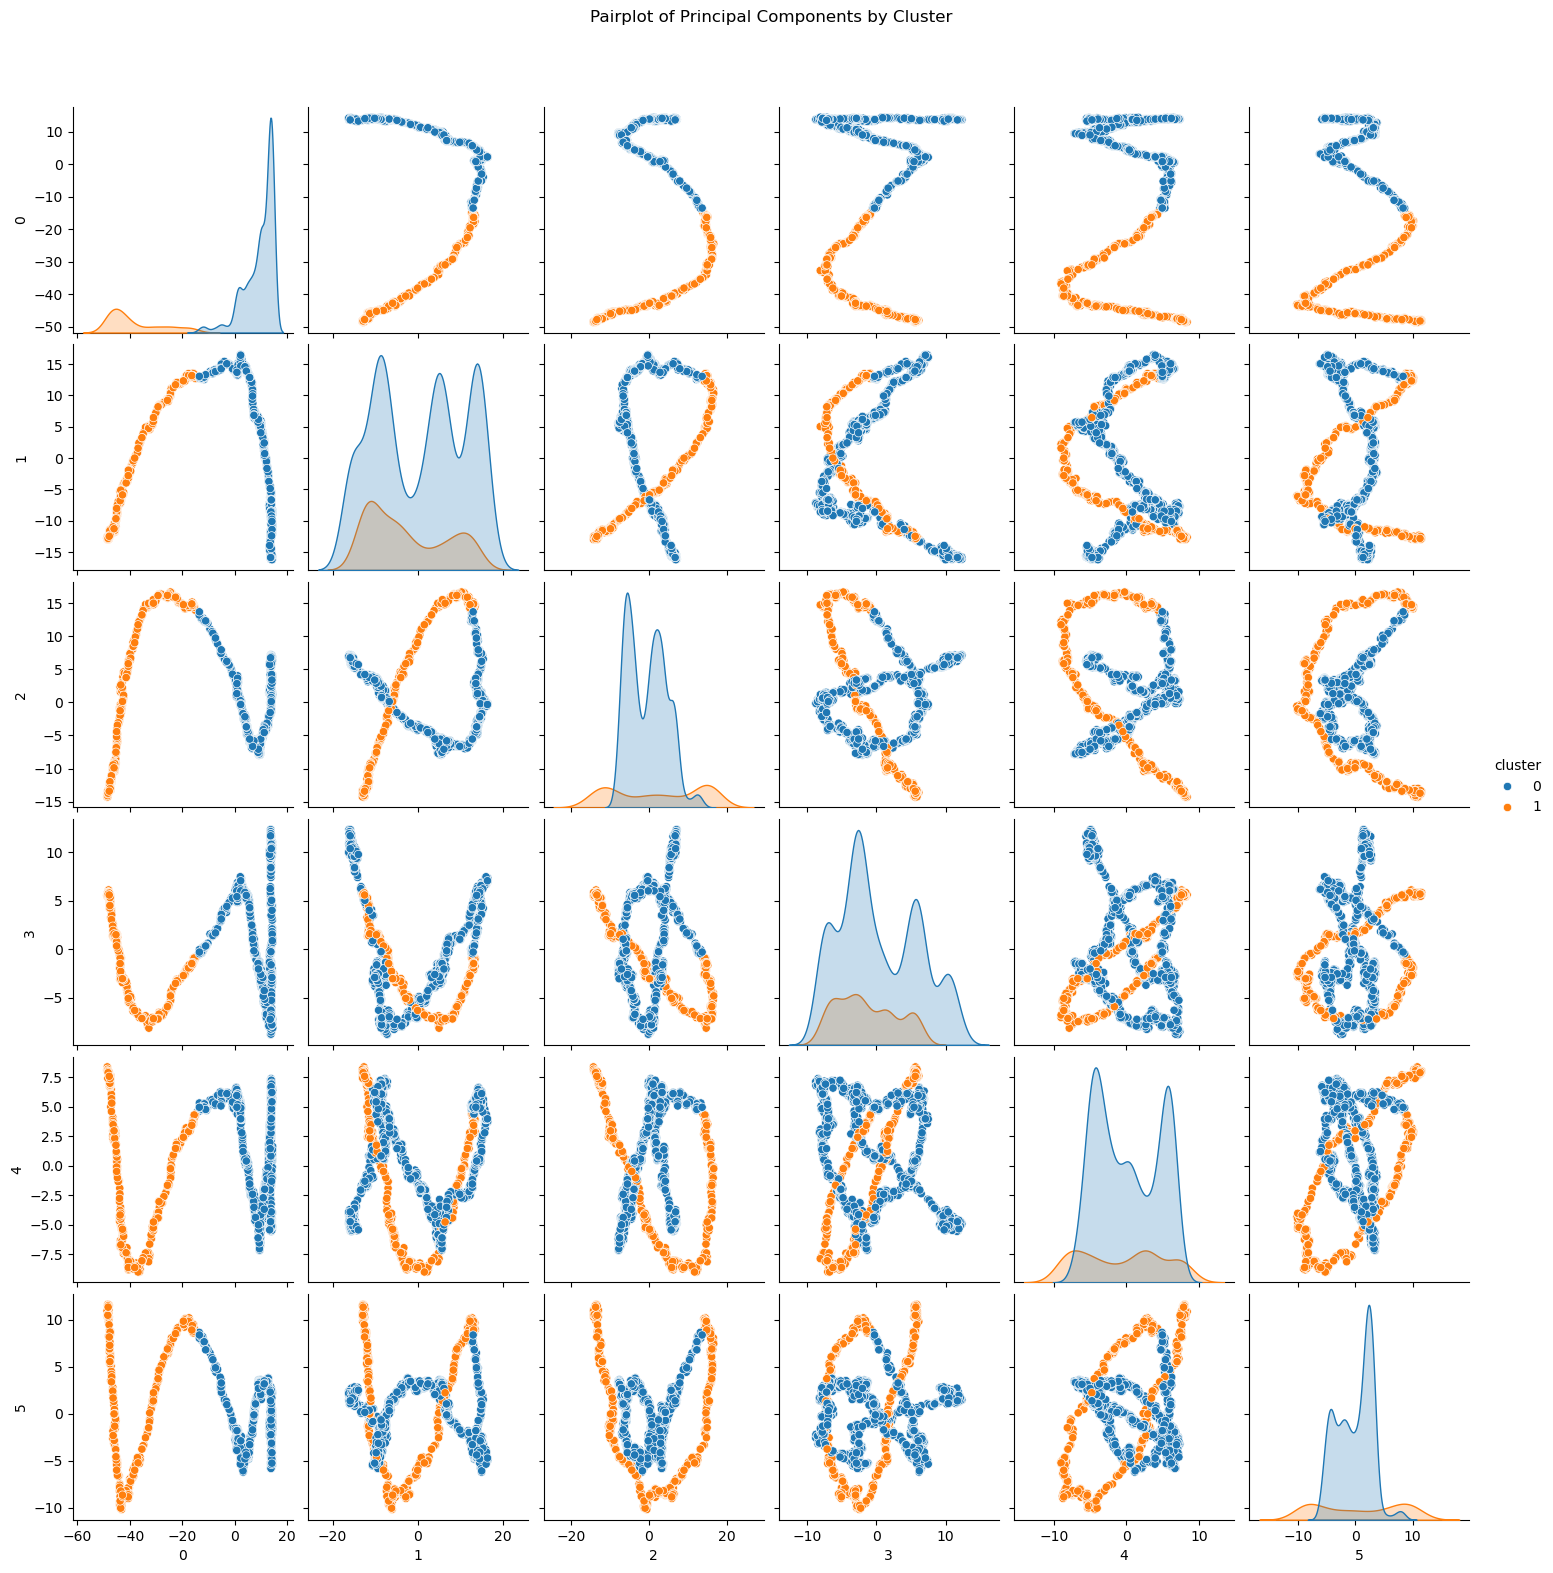

In [5]:
def objective(trial):
    
    directory_path = '/home/user/IsingData/Data/betaJ-1000_vf-050_nrows-100_ncols-100'

    n_components = trial.suggest_int("n_components", 2, 6)
    scaler_type = trial.suggest_categorical('scaler_type', ['StandardScaler', 'MinMaxScaler', 'RobustScaler', 'MaxAbsScaler', 'PowerTransformer'])

    if scaler_type ==  'StandardScaler':
        scaler_type = sklearn.preprocessing.StandardScaler()
    elif scaler_type == 'MinMaxScaler':
        scaler_type = sklearn.preprocessing.MinMaxScaler()
    elif scaler_type == 'RobustScaler':
        scaler_type = sklearn.preprocessing.RobustScaler()
    elif scaler_type == 'MaxAbsScaler':
        scaler_type = sklearn.preprocessing.MaxAbsScaler()
    elif scaler_type == 'PowerTransformer':
        scaler_type = sklearn.preprocessing.PowerTransformer()

    pca = PCA_analysis(directory=directory_path, n_components=n_components, scaler=scaler_type)
    cluster_labels = clusters(pca=pca)

    score = sklearn.metrics.silhouette_score(pca, cluster_labels)

    return score

study = optuna.create_study(direction='maximize', study_name='pca_kmeans_optimization')
    
with open('betaJ-0010_vf-050.out', 'w') as f:
    print("Starting PCA and KMeans hyperparameter optimization")
    study.optimize(objective, n_trials=3)
    print("Optimization finished.")
    print("\nPCA and KMeans Optimization Results:", file=f)
    print(f"Number of finished trials: {len(study.trials)}", file=f)
    print(f"Best trial:", file=f)
    print(f"  Value (Silhouette Score): {study.best_value:.4f}", file=f)
    print(f"  Params: {study.best_params}", file=f)

best_n_components = study.best_params['n_components']
scaler_type = study.best_params['scaler_type']

if scaler_type ==  'StandardScaler':
    scaler_type = sklearn.preprocessing.StandardScaler()
elif scaler_type == 'MinMaxScaler':
    scaler_type = sklearn.preprocessing.MinMaxScaler()
elif scaler_type == 'RobustScaler':
    scaler_type = sklearn.preprocessing.RobustScaler()
elif scaler_type == 'MaxAbsScaler':
    scaler_type = sklearn.preprocessing.MaxAbsScaler()
elif scaler_type == 'PowerTransformer':
    scaler_type = sklearn.preprocessing.PowerTransformer()

directory_path = '/home/user/IsingData/Data/betaJ-1000_vf-050_nrows-100_ncols-100'

principal_components = PCA_analysis(directory=directory_path, n_components=best_n_components, scaler=scaler_type)
cluster_and_plot(pca=principal_components, fig_name='betaJ-1000_vf-050.png')

## betaJ 0200 w 025vf

[I 2025-07-09 14:44:08,479] A new study created in memory with name: pca_kmeans_optimization


Starting PCA and KMeans hyperparameter optimization


/home/user/miniconda3/envs/Ising/lib/python3.13/site-packages/numpy/_core/_methods.py:193: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/user/miniconda3/envs/Ising/lib/python3.13/site-packages/numpy/_core/_methods.py:204: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
[I 2025-07-09 14:44:31,089] Trial 0 finished with value: 0.6012646290306866 and parameters: {'n_components': 5, 'scaler_type': 'PowerTransformer'}. Best is trial 0 with value: 0.6012646290306866.
/home/user/miniconda3/envs/Ising/lib/python3.13/site-packages/numpy/_core/_methods.py:193: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/user/miniconda3/envs/Ising/lib/python3.13/site-packages/numpy/_core/_methods.py:204: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
[I 2025-07-09 14:44:46,221] Trial 1 finished wit

Optimization finished.


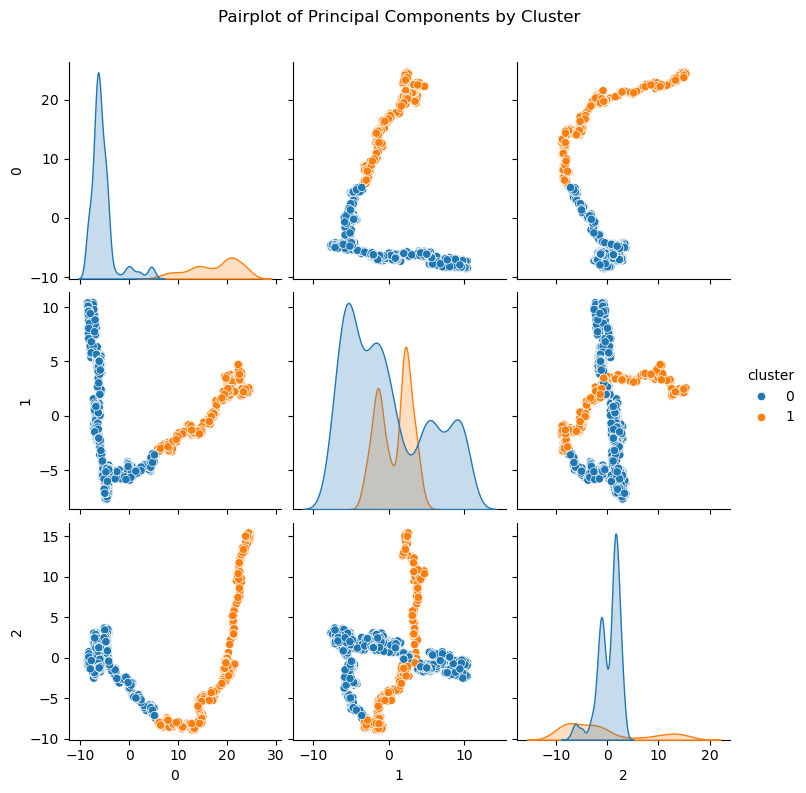

In [6]:
def objective(trial):
    
    directory_path = '/home/user/IsingData/Data/betaJ-0200_vf-025_nrows-100_ncols-100'

    n_components = trial.suggest_int("n_components", 2, 6)
    scaler_type = trial.suggest_categorical('scaler_type', ['StandardScaler', 'MinMaxScaler', 'RobustScaler', 'MaxAbsScaler', 'PowerTransformer'])

    if scaler_type ==  'StandardScaler':
        scaler_type = sklearn.preprocessing.StandardScaler()
    elif scaler_type == 'MinMaxScaler':
        scaler_type = sklearn.preprocessing.MinMaxScaler()
    elif scaler_type == 'RobustScaler':
        scaler_type = sklearn.preprocessing.RobustScaler()
    elif scaler_type == 'MaxAbsScaler':
        scaler_type = sklearn.preprocessing.MaxAbsScaler()
    elif scaler_type == 'PowerTransformer':
        scaler_type = sklearn.preprocessing.PowerTransformer()

    pca = PCA_analysis(directory=directory_path, n_components=n_components, scaler=scaler_type)
    cluster_labels = clusters(pca=pca)

    score = sklearn.metrics.silhouette_score(pca, cluster_labels)

    return score

study = optuna.create_study(direction='maximize', study_name='pca_kmeans_optimization')
    
with open('betaJ-0010_vf-050.out', 'w') as f:
    print("Starting PCA and KMeans hyperparameter optimization")
    study.optimize(objective, n_trials=3)
    print("Optimization finished.")
    print("\nPCA and KMeans Optimization Results:", file=f)
    print(f"Number of finished trials: {len(study.trials)}", file=f)
    print(f"Best trial:", file=f)
    print(f"  Value (Silhouette Score): {study.best_value:.4f}", file=f)
    print(f"  Params: {study.best_params}", file=f)

best_n_components = study.best_params['n_components']
scaler_type = study.best_params['scaler_type']

if scaler_type ==  'StandardScaler':
    scaler_type = sklearn.preprocessing.StandardScaler()
elif scaler_type == 'MinMaxScaler':
    scaler_type = sklearn.preprocessing.MinMaxScaler()
elif scaler_type == 'RobustScaler':
    scaler_type = sklearn.preprocessing.RobustScaler()
elif scaler_type == 'MaxAbsScaler':
    scaler_type = sklearn.preprocessing.MaxAbsScaler()
elif scaler_type == 'PowerTransformer':
    scaler_type = sklearn.preprocessing.PowerTransformer()

directory_path = '/home/user/IsingData/Data/betaJ-0200_vf-025_nrows-100_ncols-100'

principal_components = PCA_analysis(directory=directory_path, n_components=best_n_components, scaler=scaler_type)
cluster_and_plot(pca=principal_components, fig_name='betaJ-0200_vf-025.png')

## betaJ 0200 vf 050

[I 2025-07-09 14:45:16,580] A new study created in memory with name: pca_kmeans_optimization


Starting PCA and KMeans hyperparameter optimization


[I 2025-07-09 14:45:37,787] Trial 0 finished with value: 0.5111790949665825 and parameters: {'n_components': 5, 'scaler_type': 'MinMaxScaler'}. Best is trial 0 with value: 0.5111790949665825.
[I 2025-07-09 14:45:50,766] Trial 1 finished with value: 0.5155722495512655 and parameters: {'n_components': 5, 'scaler_type': 'StandardScaler'}. Best is trial 1 with value: 0.5155722495512655.
/home/user/miniconda3/envs/Ising/lib/python3.13/site-packages/numpy/_core/_methods.py:193: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/user/miniconda3/envs/Ising/lib/python3.13/site-packages/numpy/_core/_methods.py:204: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
[I 2025-07-09 14:46:11,851] Trial 2 finished with value: 0.6200942491700753 and parameters: {'n_components': 2, 'scaler_type': 'PowerTransformer'}. Best is trial 2 with value: 0.6200942491700753.


Optimization finished.


/home/user/miniconda3/envs/Ising/lib/python3.13/site-packages/numpy/_core/_methods.py:193: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/user/miniconda3/envs/Ising/lib/python3.13/site-packages/numpy/_core/_methods.py:204: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


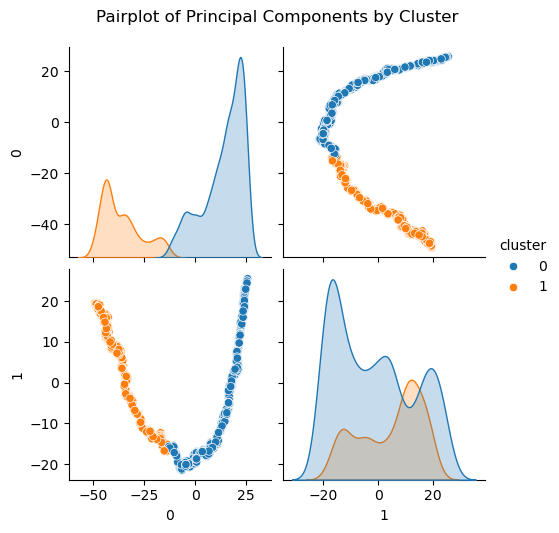

In [7]:
def objective(trial):
    
    directory_path = '/home/user/IsingData/Data/betaJ-0200_vf-050_nrows-100_ncols-100'

    n_components = trial.suggest_int("n_components", 2, 6)
    scaler_type = trial.suggest_categorical('scaler_type', ['StandardScaler', 'MinMaxScaler', 'RobustScaler', 'MaxAbsScaler', 'PowerTransformer'])

    if scaler_type ==  'StandardScaler':
        scaler_type = sklearn.preprocessing.StandardScaler()
    elif scaler_type == 'MinMaxScaler':
        scaler_type = sklearn.preprocessing.MinMaxScaler()
    elif scaler_type == 'RobustScaler':
        scaler_type = sklearn.preprocessing.RobustScaler()
    elif scaler_type == 'MaxAbsScaler':
        scaler_type = sklearn.preprocessing.MaxAbsScaler()
    elif scaler_type == 'PowerTransformer':
        scaler_type = sklearn.preprocessing.PowerTransformer()

    pca = PCA_analysis(directory=directory_path, n_components=n_components, scaler=scaler_type)
    cluster_labels = clusters(pca=pca)

    score = sklearn.metrics.silhouette_score(pca, cluster_labels)

    return score

study = optuna.create_study(direction='maximize', study_name='pca_kmeans_optimization')
    
with open('betaJ-0010_vf-050.out', 'w') as f:
    print("Starting PCA and KMeans hyperparameter optimization")
    study.optimize(objective, n_trials=3)
    print("Optimization finished.")
    print("\nPCA and KMeans Optimization Results:", file=f)
    print(f"Number of finished trials: {len(study.trials)}", file=f)
    print(f"Best trial:", file=f)
    print(f"  Value (Silhouette Score): {study.best_value:.4f}", file=f)
    print(f"  Params: {study.best_params}", file=f)

best_n_components = study.best_params['n_components']
scaler_type = study.best_params['scaler_type']

if scaler_type ==  'StandardScaler':
    scaler_type = sklearn.preprocessing.StandardScaler()
elif scaler_type == 'MinMaxScaler':
    scaler_type = sklearn.preprocessing.MinMaxScaler()
elif scaler_type == 'RobustScaler':
    scaler_type = sklearn.preprocessing.RobustScaler()
elif scaler_type == 'MaxAbsScaler':
    scaler_type = sklearn.preprocessing.MaxAbsScaler()
elif scaler_type == 'PowerTransformer':
    scaler_type = sklearn.preprocessing.PowerTransformer()

directory_path = '/home/user/IsingData/Data/betaJ-0200_vf-050_nrows-100_ncols-100'

principal_components = PCA_analysis(directory=directory_path, n_components=best_n_components, scaler=scaler_type)
cluster_and_plot(pca=principal_components, fig_name='betaJ-0200_vf-050.png')

## betaJ 0200 vf 080

[I 2025-07-09 14:46:31,190] A new study created in memory with name: pca_kmeans_optimization


Starting PCA and KMeans hyperparameter optimization


[I 2025-07-09 14:46:51,733] Trial 0 finished with value: 0.5600886871590449 and parameters: {'n_components': 2, 'scaler_type': 'RobustScaler'}. Best is trial 0 with value: 0.5600886871590449.
[I 2025-07-09 14:47:04,371] Trial 1 finished with value: 0.6474474746203225 and parameters: {'n_components': 2, 'scaler_type': 'MinMaxScaler'}. Best is trial 1 with value: 0.6474474746203225.
[I 2025-07-09 14:47:16,823] Trial 2 finished with value: 0.6474474746201994 and parameters: {'n_components': 2, 'scaler_type': 'MaxAbsScaler'}. Best is trial 1 with value: 0.6474474746203225.


Optimization finished.


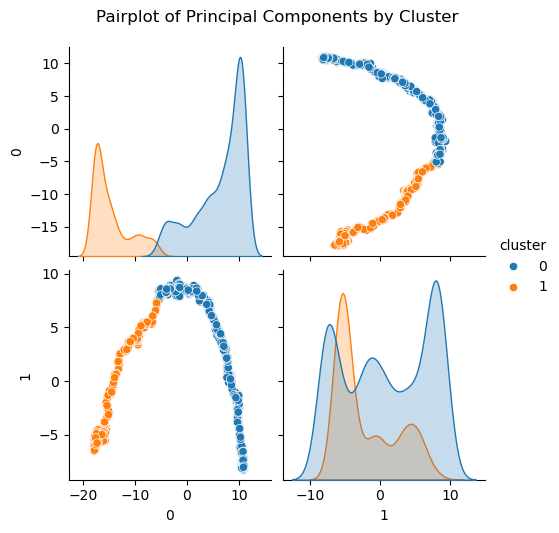

In [ ]:
def objective(trial):
        
            directory_path = '/home/user/IsingData/Data/betaJ-0200_vf-080_nrows-100_ncols-100'

                n_components = trial.suggest_int("n_components", 2, 6)
                    scaler_type = trial.suggest_categorical('scaler_type', ['StandardScaler', 'MinMaxScaler', 'RobustScaler', 'MaxAbsScaler', 'PowerTransformer'])

                        if scaler_type ==  'StandardScaler':
                                scaler_type = sklearn.preprocessing.StandardScaler()
                                    elif scaler_type == 'MinMaxScaler':
                                            scaler_type = sklearn.preprocessing.MinMaxScaler()
                                                elif scaler_type == 'RobustScaler':
                                                        scaler_type = sklearn.preprocessing.RobustScaler()
                                                            elif scaler_type == 'MaxAbsScaler':
                                                                    scaler_type = sklearn.preprocessing.MaxAbsScaler()
                                                                        elif scaler_type == 'PowerTransformer':
                                                                                scaler_type = sklearn.preprocessing.PowerTransformer()

                                                                                    pca = PCA_analysis(directory=directory_path, n_components=n_components, scaler=scaler_type)
                                                                                        cluster_labels = clusters(pca=pca)

                                                                                            score = sklearn.metrics.silhouette_score(pca, cluster_labels)

                                                                                                return score

                                                                                                study = optuna.create_study(direction='maximize', study_name='pca_kmeans_optimization')
                                                                                                    
                                                                                                    with open('betaJ-0010_vf-050.out', 'w') as f:
                                                                                                        print("Starting PCA and KMeans hyperparameter optimization")
                                                                                                            study.optimize(objective, n_trials=3)
                                                                                                                print("Optimization finished.")
                                                                                                                    print("\nPCA and KMeans Optimization Results:", file=f)
                                                                                                                        print(f"Number of finished trials: {len(study.trials)}", file=f)
                                                                                                                            print(f"Best trial:", file=f)
                                                                                                                                print(f"  Value (Silhouette Score): {study.best_value:.4f}", file=f)
                                                                                                                                    print(f"  Params: {study.best_params}", file=f)

                                                                                                                                    best_n_components = study.best_params['n_components']
                                                                                                                                    scaler_type = study.best_params['scaler_type']

                                                                                                                                    if scaler_type ==  'StandardScaler':
                                                                                                                                        scaler_type = sklearn.preprocessing.StandardScaler()
                                                                                                                                        elif scaler_type == 'MinMaxScaler':
                                                                                                                                            scaler_type = sklearn.preprocessing.MinMaxScaler()
                                                                                                                                            elif scaler_type == 'RobustScaler':
                                                                                                                                                scaler_type = sklearn.preprocessing.RobustScaler()
                                                                                                                                                elif scaler_type == 'MaxAbsScaler':
                                                                                                                                                    scaler_type = sklearn.preprocessing.MaxAbsScaler()
                                                                                                                                                    elif scaler_type == 'PowerTransformer':
                                                                                                                                                        scaler_type = sklearn.preprocessing.PowerTransformer()

                                                                                                                                                        directory_path = '/home/user/IsingData/Data/betaJ-0200_vf-050_nrows-100_ncols-100'

                                                                                                                                                        principal_components = PCA_analysis(directory=directory_path, n_components=best_n_components, scaler=scaler_type)
                                                                                                                                                        cluster_and_plot(pca=principal_components, fig_name='betaJ-0200_vf-080.png')